## 2. Predicting High School Student Performance

In [24]:
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np
from tpot import TPOTRegressor
import shap
import matplotlib.pyplot as plt

### i. Using TPOT to find the best Model

In [25]:
df = pd.read_csv('student-mat.csv', delimiter=';')

In [26]:
display(df)
df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

### Encoding of categorical variables

#### List of categorical columns

In [27]:
categorical_columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 
                       'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 
                       'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

In [28]:
print("Columns in dataframe:", df.columns)

Columns in dataframe: Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')


#### Label Encoding for binary categorical variables

In [29]:
label_enc_columns = ['sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 
                     'higher', 'internet', 'romantic']
label_encoders = {col: LabelEncoder() for col in label_enc_columns}

for col in label_enc_columns:
    if col in df.columns:
        df[col] = label_encoders[col].fit_transform(df[col])

In [30]:
onehot_enc_columns = list(set(categorical_columns) - set(label_enc_columns))
onehot_enc_columns = [col for col in onehot_enc_columns if col in df.columns]
df = pd.get_dummies(df, columns=onehot_enc_columns)

print(df.head())

   sex  address  famsize  Pstatus  schoolsup  famsup  paid  activities  \
0    0        1        0        0          1       0     0           0   
1    0        1        0        1          0       1     0           0   
2    0        1        1        1          1       0     1           0   
3    0        1        0        1          0       1     1           1   
4    0        1        0        1          0       1     1           0   

   nursery  higher  ...  Mjob_other  Mjob_services  Mjob_teacher  \
0        1       1  ...       False          False         False   
1        0       1  ...       False          False         False   
2        1       1  ...       False          False         False   
3        1       1  ...       False          False         False   
4        1       1  ...        True          False         False   

   guardian_father  guardian_mother  guardian_other  failures_0  failures_1  \
0            False             True           False        True    

### Split the data into training and testing sets

In [31]:
X = df.drop('G3', axis=1)
y = df['G3']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training set size: {X_train.shape[0]}')
print(f'Testing set size: {X_test.shape[0]}')

Training set size: 316
Testing set size: 79


In [32]:
tpot = TPOTRegressor(verbosity=2, generations=5, population_size=20, random_state=42)
tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.1135997787160767

Generation 2 - Current best internal CV score: -2.1135997787160767

Generation 3 - Current best internal CV score: -2.1135997787160767

Generation 4 - Current best internal CV score: -2.0364439541990613

Generation 5 - Current best internal CV score: -2.0364439541990613

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=square, n_estimators=100)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

#### R² metric on the testing set

In [33]:
r2_score = tpot.score(X_test, y_test)
print(f'R² score on the test set: {r2_score}')

R² score on the test set: -5.238515306965142


#### Export the best pipeline

In [34]:
tpot.export('best_pipeline.py')

### ii. Using Optuna to find the best Model

#### Objective function for Random Forest and Gradient Boosting

In [35]:
def objective(trial):
    model_name = trial.suggest_categorical('model', ['RandomForest', 'GradientBoosting'])
    if model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    elif model_name == 'GradientBoosting':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 20)
        model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    return score

#### Optimization

In [36]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-06-07 11:40:24,172] A new study created in memory with name: no-name-15310997-5ef5-4541-b7bd-b647338e75a9
[I 2024-06-07 11:40:26,678] Trial 0 finished with value: 0.8964465347959318 and parameters: {'model': 'RandomForest', 'n_estimators': 178, 'max_depth': 16, 'min_samples_split': 6}. Best is trial 0 with value: 0.8964465347959318.
[I 2024-06-07 11:40:29,571] Trial 1 finished with value: 0.7975068937063682 and parameters: {'model': 'GradientBoosting', 'n_estimators': 179, 'learning_rate': 0.047189657468972364, 'max_depth': 18}. Best is trial 0 with value: 0.8964465347959318.
[I 2024-06-07 11:40:30,146] Trial 2 finished with value: 0.8820460144974639 and parameters: {'model': 'GradientBoosting', 'n_estimators': 92, 'learning_rate': 0.2946823502412603, 'max_depth': 3}. Best is trial 0 with value: 0.8964465347959318.
[I 2024-06-07 11:40:32,415] Trial 3 finished with value: 0.8028095823609955 and parameters: {'model': 'GradientBoosting', 'n_estimators': 142, 'learning_rate': 0.022

#### Print the best parameters

In [37]:
print('Best trial:')
trial = study.best_trial
print(f'  R²: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

Best trial:
  R²: 0.9016599812010112
  Params: 
    model: RandomForest
    n_estimators: 105
    max_depth: 6
    min_samples_split: 3


#### Train the best model on the full training set and evaluate on the test set

In [38]:
if trial.params['model'] == 'RandomForest':
    best_model = RandomForestRegressor(n_estimators=trial.params['n_estimators'],
                                       max_depth=trial.params['max_depth'],
                                       min_samples_split=trial.params['min_samples_split'],
                                       random_state=42)
elif trial.params['model'] == 'GradientBoosting':
    best_model = GradientBoostingRegressor(n_estimators=trial.params['n_estimators'],
                                           learning_rate=trial.params['learning_rate'],
                                           max_depth=trial.params['max_depth'],
                                           random_state=42)

In [39]:
from sklearn.metrics import r2_score
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'R² score on the test set: {r2}')

R² score on the test set: 0.7982012249349615


#### Calculate and Summary Plot of SHAP values

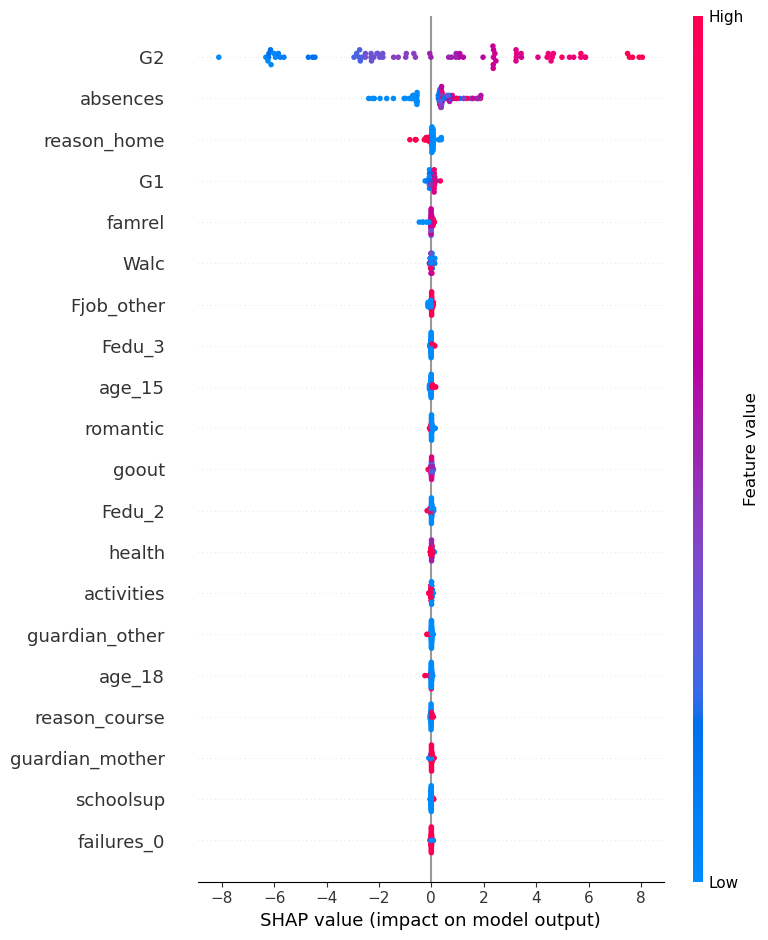

In [40]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

In [42]:
### Discussion about the SHAP summary plot:

# At the forefront of feature importance is G2 (second period grade), which exhibits the highest SHAP values, indicating its substantial 
influence on the model's predictions. The plot shows a clear trend where higher values of G2 (represented by red points) significantly 
increase the predicted output, while lower values (blue points) result in a decrease. This strong correlation suggests that G2 is a 
critical determinant in the model’s decision-making process.
    
# Following closely, is absences (number of absences), where the SHAP values predominantly show a negative impact on the model's predictions. 
This negative influence is particularly evident with higher absence values, which cluster on the negative side of the SHAP value spectrum, 
suggesting that increased absences are detrimental to the predicted outcome which is G3 (final grade).

# Reason (close to home) also plays a notable role, generally exerting a negative influence on the model's predictions. The plot indicates that 
when this feature is activated (higher values), it tends to lower the G3, reflecting that choosing the school based on it’s proximity to the 
student’s home might be associated with lower performance or outcomes in the model’s context.
    
# The feature G1 mirrors the pattern observed with G2, although with slightly lesser impact. Higher values of G1 contribute positively to the 
prediction, indicating that early performance (as measured by G1) is a strong indicator of the final outcome predicted by the model.

# Other features like famrel (quality of family relation) and Walc (weekend alcohol consumption) exhibit more nuanced impacts. Quality of family 
relation generally has a positive influence, although less pronounced than G1 and G2, while weekend alcohol consumption shows varied effects 
across its value range, indicating potential complex interactions with other features.

# Conversely, features such as failures_0 (number of past class failures) and schoolsup (extra educational school support) display minimal 
impact on the model's predictions, as evidenced by their SHAP values clustering around zero. This suggests that these features do not 
significantly sway the model’s output in either direction.
    
# The color coding in the plot provides additional insights into the nature of these impacts. For instance, high values of Fedu_3 (father's education) 
are marked in red and tend to increase the model’s predictions, indicating a positive correlation between higher educational levels and the outcome. 
Similarly, lower health status (blue points for health) slightly decreases the predictions, although its overall impact remains modest.



SyntaxError: unterminated string literal (detected at line 4) (1970316382.py, line 4)